The challenge revolves around are we able to predict pneumonia with a degree of accuracy from chest x-rays using traditional machine learning algorithms (classification) instead of just using CNNs? 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

from sklearn.ensemble import AdaBoostClassifier

# Loading and saving images as .npy files so we could deal with them

In [5]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

### Load data without Histogram Technique (don't run)

In [6]:
trainpath='chest_xray/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [133]:
# testpath='../input/chest-xray-pneumonia/chest_xray/test/'
testpath='chest_xray/test/'
X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

### Load data with Adaptive Histogram Equalization as Preprocessing Method (run)

In [7]:
trainpath='chest_xray/train/'

X_train_pre = []
y_train_pre = []
counter = 0
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv.imread(file, cv.IMREAD_GRAYSCALE)
        #resize images to 64 x 64 pixels
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(image)
        # cv.imwrite('pre/' + str(counter) + '.jpg', cl1)
        image_array = cv.resize(cl1 , (64,64))
        X_train_pre.append(list(image_array))
        y_train_pre.append(code[folder])
        counter += 1 

np.save('X_train_pre',X_train_pre)
np.save('y_train_pre',y_train_pre)



In [8]:
testpath='chest_xray/test/'
X_test_pre = []
y_test_pre = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv.imread(file, cv.IMREAD_GRAYSCALE)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(image)
        #resize images to 64 x 64 pixels
        image_array = cv.resize(cl1 , (64,64))
        X_test_pre.append(list(image_array))
        y_test_pre.append(code[folder])
np.save('X_test_pre',X_test_pre)
np.save('y_test_pre',y_test_pre)

# Loading the .npy files as numpy arrays

In [9]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image 
# loaded_X_train = np.load('./X_train.npy')
# loaded_X_test = np.load('./X_test.npy')
# loaded_y_train = np.load('./y_train.npy')
# loaded_y_test = np.load('./y_test.npy')

loaded_X_train = np.load('./X_train_pre.npy')
loaded_X_test = np.load('./X_test_pre.npy')
loaded_y_train = np.load('./y_train_pre.npy')
loaded_y_test = np.load('./y_test_pre.npy')


In [10]:
print(loaded_X_train.shape)
print(loaded_X_train[0].shape)
print(loaded_X_test.shape)
print(loaded_X_test[0].shape)


(5216, 64, 64)
(64, 64)
(624, 64, 64)
(64, 64)


# Data Analysis

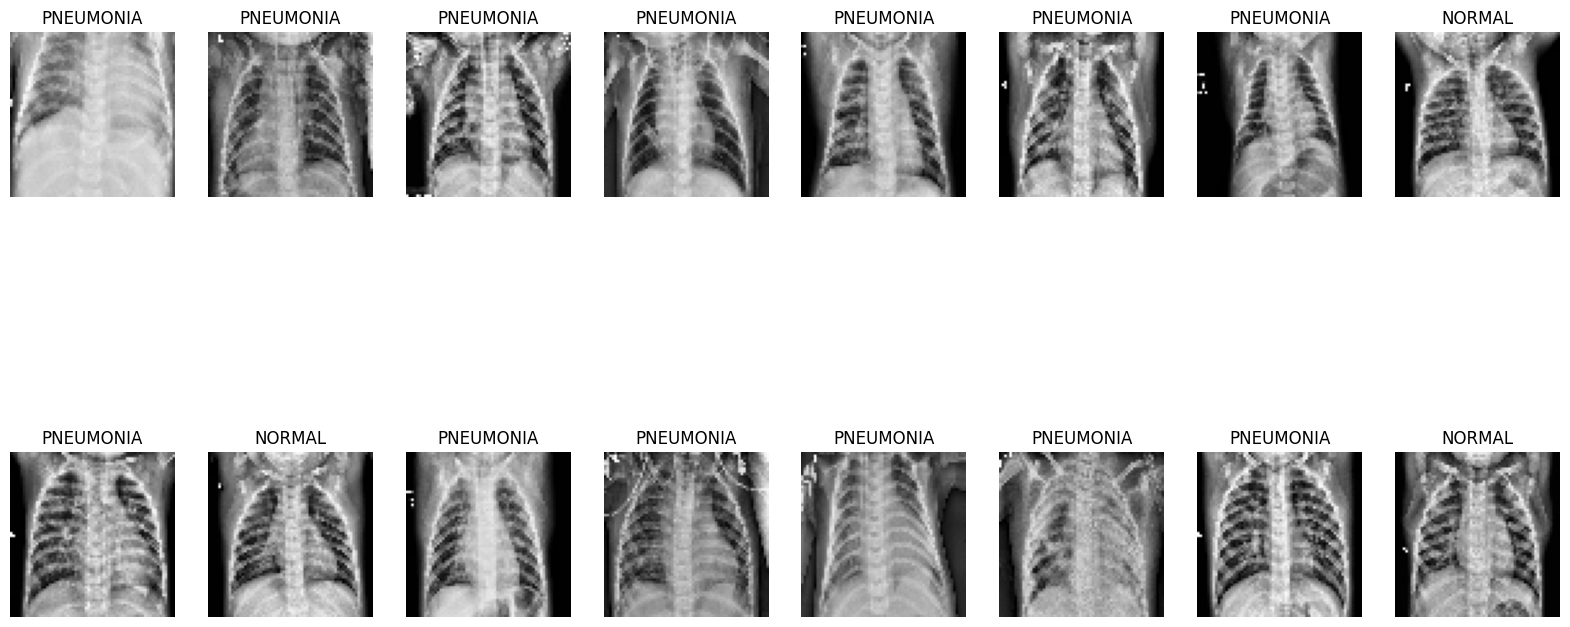

In [11]:
#plotting images of NORMAL and PNEUMONIA
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)): 
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i], cmap='gray')
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

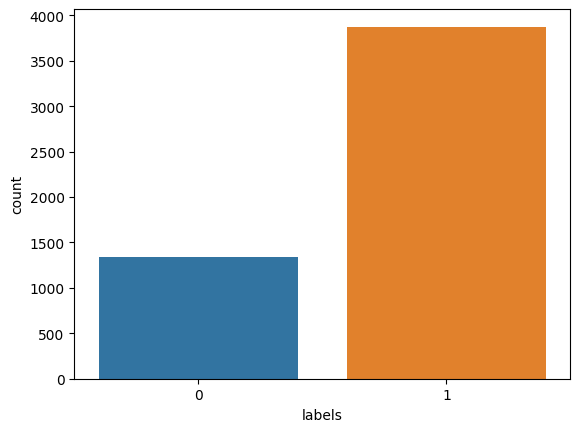

In [12]:
#count plot to show the number of pneumonia cases to normal cases in the train data set
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
lab = df_train['labels']
dist = lab.value_counts()
sns.countplot(data=df_train, x='labels')
plt.show()

As we can see pnuemonia cases are over represented in the train data set. We will deal with such imbalance later

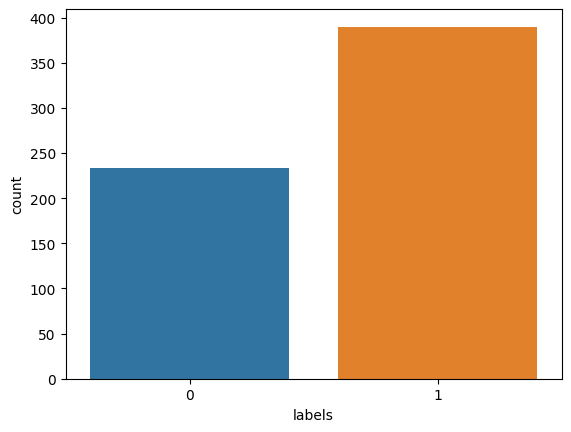

In [13]:
#count plot to show the number of pneumonia cases to normal cases in the test data set

df_test = pd.DataFrame()
df_test["labels"]= loaded_y_test
lab = df_test['labels']
dist = lab.value_counts()
#play with pallette colors
sns.countplot(data=df_test, x='labels')
plt.show()

### Histogram doesnt work rn bc it needs RGB values (don't run)

In [ ]:
#function to plot the pixel intensity of each image. 
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a, cmap='gray')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 256
    plt.hist(a, bins= n_bins, range=(0,1))
    

In [ ]:
# plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

Flatten and shuffle train and test sets 

In [14]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64))])
X_test = loaded_X_test.reshape([-1, np.product((64,64))])

In [15]:
print(X_train.shape)
print(X_test.shape)

(5216, 4096)
(624, 4096)


In [16]:
y_train = loaded_y_train
y_test = loaded_y_test

In [17]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

# Testing classification algorithms without any preprocessing 

In [93]:
# making an instance of each algorithm
log_reg  = LogisticRegression()
svm = SVC()
knn = KNeighborsClassifier(n_neighbors=6)
dtc  = DecisionTreeClassifier()

In [94]:
# fitting each model using X_train and y_train
log_reg.fit(X_train, y_train)
svm.fit(X_train, y_train)
knn.fit(X_train, y_train)
dtc.fit(X_train, y_train)


C:\Users\ebosc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeClassifier()

In [95]:

#scoring each model

print('Logistic Regression Train accuracy score is: ' + str(log_reg.score(X_train, y_train)))
print('Logistic Regression Test accuracy score is: ' + str(log_reg.score(X_test, y_test)))

print('SVM Train accuracy score is: ' + str(svm.score(X_train, y_train)))
print('SVM Test accuracy score is: ' + str(svm.score(X_test, y_test)))

print('KNN Train accuracy score is: ' + str(knn.score(X_train, y_train)))
print('KNN Test accuracy score is: ' + str(knn.score(X_test, y_test)))

print('Decision Tree Classifier Train accuracy score is: ' + str(dtc.score(X_train, y_train)))
print('Decision Tree Classifier Test accuracy score is: ' + str(dtc.score(X_test, y_test)))

Logistic Regression Train accuracy score is: 1.0
Logistic Regression Test accuracy score is: 0.7564102564102564
SVM Train accuracy score is: 0.9888803680981595
SVM Test accuracy score is: 0.7788461538461539
KNN Train accuracy score is: 0.9539877300613497
KNN Test accuracy score is: 0.7612179487179487
Decision Tree Classifier Train accuracy score is: 1.0
Decision Tree Classifier Test accuracy score is: 0.7467948717948718


In [99]:
#making predictions for each model

log_reg_predicted = log_reg.predict(X_test)
svm_predicted = svm.predict(X_test)

knn_predicted = knn.predict(X_test)
dtc_predicted = dtc.predict(X_test)

print(classification_report(y_true=y_test, y_pred=log_reg_predicted))
print(classification_report(y_true=y_test, y_pred=svm_predicted))

print(classification_report(y_true=y_test, y_pred=knn_predicted))
print(classification_report(y_true=y_test, y_pred=dtc_predicted))

              precision    recall  f1-score   support

           0       0.95      0.37      0.53       234
           1       0.72      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.83      0.68      0.68       624
weighted avg       0.81      0.76      0.72       624

              precision    recall  f1-score   support

           0       0.99      0.41      0.58       234
           1       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624

              precision    recall  f1-score   support

           0       0.98      0.37      0.54       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.69       624
weighted avg       0.82      0.76      0.73       624

              preci

In [91]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

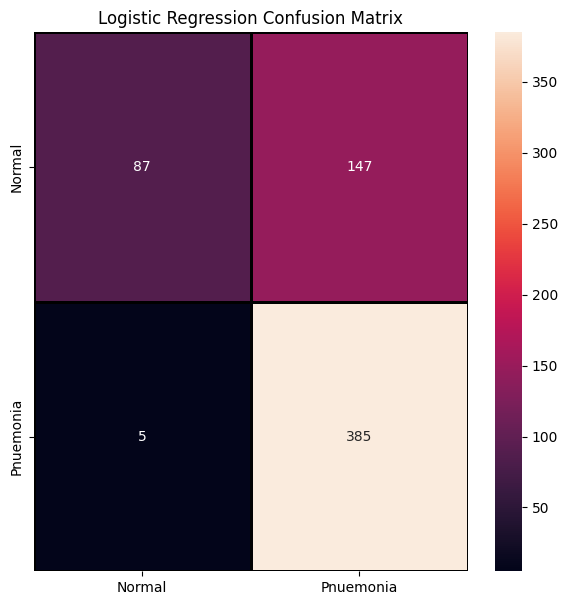

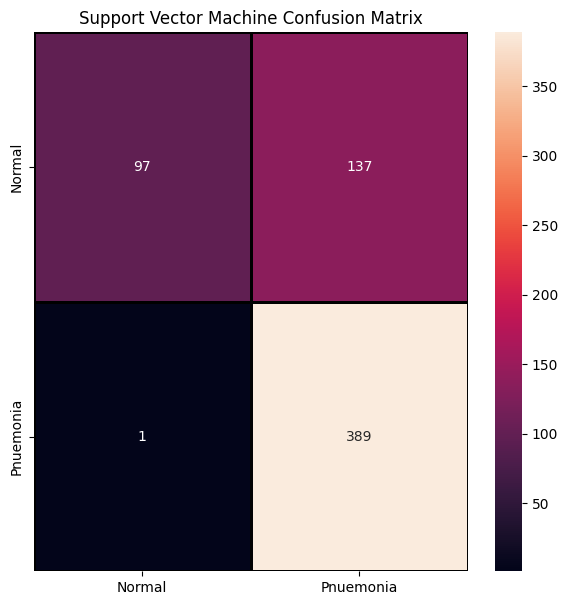

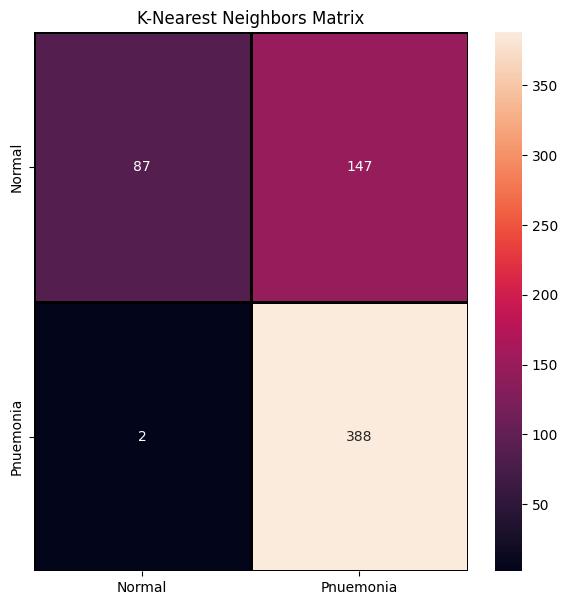

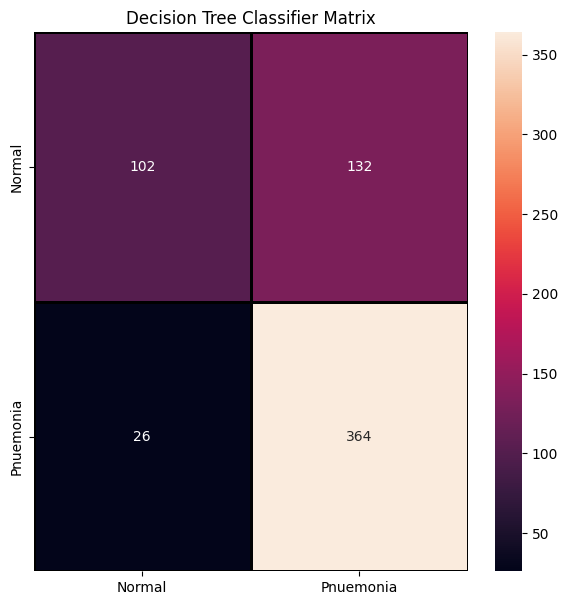

In [97]:
#plot confusion matrix for each model
plot_cm(log_reg_predicted, y_test, 'Logistic Regression Confusion Matrix') 
plot_cm(svm_predicted, y_test, 'Support Vector Machine Confusion Matrix')

plot_cm(knn_predicted, y_test, 'K-Nearest Neighbors Matrix') 
plot_cm(dtc_predicted, y_test, 'Decision Tree Classifier Matrix')



### Scaling

In [20]:
#Scaling
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

### PCA

In [21]:
# Prepare training and testing data with PCA
pca = PCA(.95)
pca.fit(X_train_scaled)

X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

#printing the variance of each component from PCA
print('Number of components after PCA: ' + str(pca.n_components_))


Number of components after PCA: 1208


### Training with PCA

Logistic Regression training accuracy score is: 1.0
Logistic Regression accuracy score is: 0.8012820512820513
              precision    recall  f1-score   support

           0       0.90      0.53      0.67       234
           1       0.77      0.96      0.86       390

    accuracy                           0.80       624
   macro avg       0.84      0.75      0.76       624
weighted avg       0.82      0.80      0.79       624



C:\Users\ebosc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


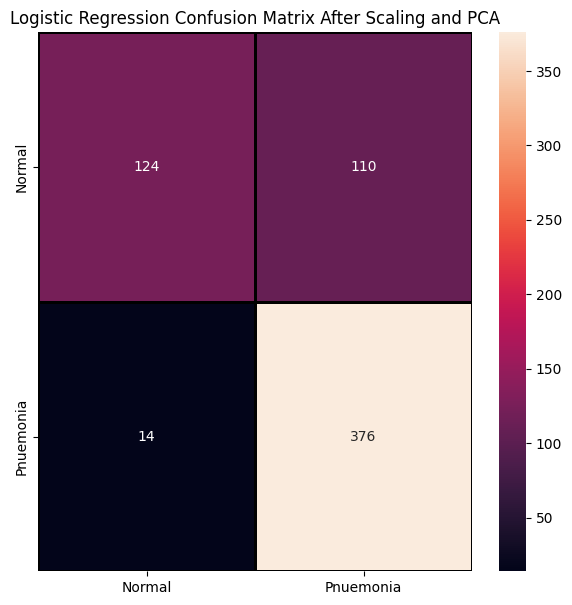

In [158]:
# Log reg

# Create instance and fit the model 
log_reg_PCA  = LogisticRegression()
log_reg_PCA.fit(X_train_PCA, y_train)

# Print accuracy scores 
print('Logistic Regression training accuracy score is: ' + str(log_reg_PCA.score(X_train_PCA, y_train)))
print('Logistic Regression accuracy score is: ' + str(log_reg_PCA.score(X_test_PCA, y_test)))

# Generate confusion matrix plot and classification report 
log_reg_PCA_predicted = log_reg_PCA.predict(X_test_PCA)
print(classification_report(y_true=y_test, y_pred=log_reg_PCA_predicted))
plot_cm(log_reg_PCA_predicted, y_test, 'Logistic Regression Confusion Matrix After Scaling and PCA') 

SVM training accuracy score is: 0.995590490797546
Support Vector Machine Classifier accuracy score is: 0.8125
              precision    recall  f1-score   support

           0       0.95      0.53      0.68       234
           1       0.78      0.98      0.87       390

    accuracy                           0.81       624
   macro avg       0.86      0.76      0.77       624
weighted avg       0.84      0.81      0.80       624



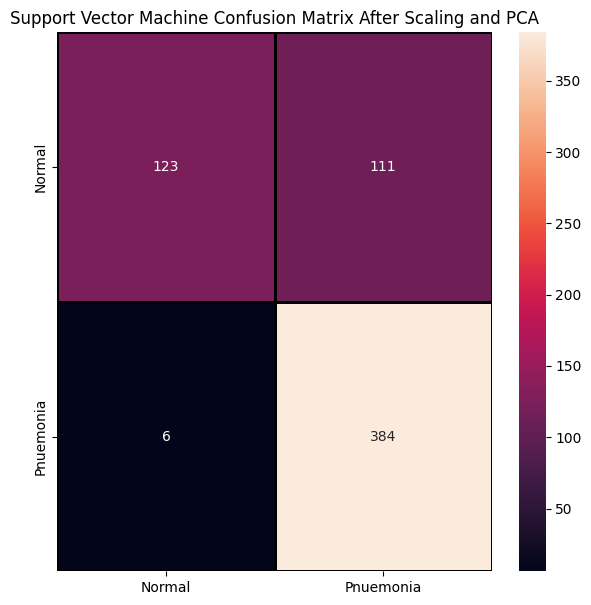

In [159]:
# SVM

# Create instance and fit the model
svm_PCA = SVC()
svm_PCA.fit(X_train_PCA, y_train)

# Print accuracy scores
print('SVM training accuracy score is: ' + str(svm_PCA.score(X_train_PCA, y_train)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm_PCA.score(X_test_PCA, y_test)))

# Generate confusion matrix plot and classification report 
svm_PCA_predicted = svm_PCA.predict(X_test_PCA)
print(classification_report(y_true=y_test, y_pred=svm_PCA_predicted))
plot_cm(svm_PCA_predicted, y_test, 'Support Vector Machine Confusion Matrix After Scaling and PCA')

k-NN training accuracy score is: 1.0
k-NN testing accuracy score is: 0.7419871794871795
              precision    recall  f1-score   support

           0       0.99      0.32      0.48       234
           1       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624



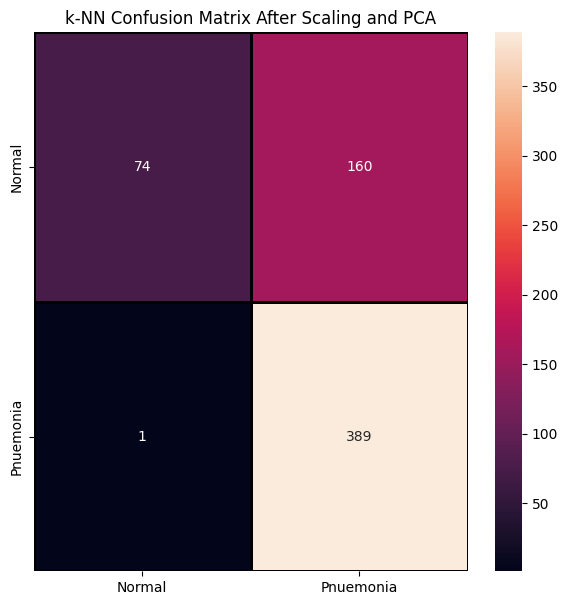

In [80]:
# k-NN with 
# 14 neighbors = 0.93, 0.71
# 13 neighbors = 0.93, 0.71
# 12 neighbors = 0.93, 0.72
# 11 neighbors = 0.93, 0.71
# 10 neighbors = 0.93, 0.73
# 9 neighbors = 0.93, 0.71
# 8 neighbors = 0.94, 0.73
# 7 neighbors = 0.94, 0.72
# 6 neighbors = 0.95, 0.75 (best)
# 5 neighbors = 0.94, 0.73
# 4 neighbors = 0.94, 0.72
# 3 neighbors = 0.95, 0.73
# 2 neighbors = 0.98, 0.80 (overfit)
# 1 neighbors = 1.0, 0.74

# Create instance and fit the model
knn_PCA = KNeighborsClassifier(n_neighbors=1)
knn_PCA.fit(X_train_PCA, y_train)

# Print accuracy scores
print('k-NN training accuracy score is: ' + str(knn_PCA.score(X_train_PCA, y_train)))
print('k-NN testing accuracy score is: ' + str(knn_PCA.score(X_test_PCA, y_test)))

# Generate confusion matrix plot and classification report 
knn_PCA_predicted = knn_PCA.predict(X_test_PCA)
print(classification_report(y_true=y_test, y_pred=knn_PCA_predicted))
plot_cm(knn_PCA_predicted, y_test, 'k-NN Confusion Matrix After Scaling and PCA')

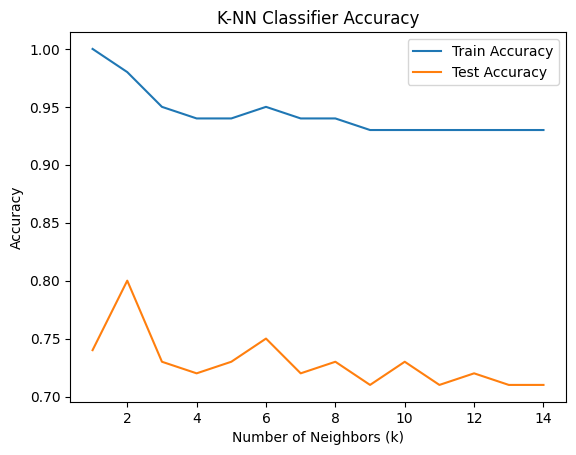

In [81]:
# plotting k-values and their accuracies

import matplotlib.pyplot as plt

# Define the data
k_values = [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
accuracy1 = [0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.95, 0.94, 0.94, 0.95, 0.98, 1.0]
accuracy2 = [0.71, 0.71, 0.72, 0.71, 0.73, 0.71, 0.73, 0.72, 0.75, 0.73, 0.72, 0.73, 0.80, 0.74]

# Create the plot
plt.plot(k_values, accuracy1, label='Train Accuracy')
plt.plot(k_values, accuracy2, label='Test Accuracy')

# Add labels and title
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('K-NN Classifier Accuracy')

# Add a legend
plt.legend()

# Display the plot
plt.show()


Decision Tree Classifier training accuracy score is: 1.0
Decision Tree Classifier testing accuracy score is: 0.780448717948718
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       234
           1       0.77      0.94      0.84       390

    accuracy                           0.78       624
   macro avg       0.80      0.73      0.74       624
weighted avg       0.79      0.78      0.77       624



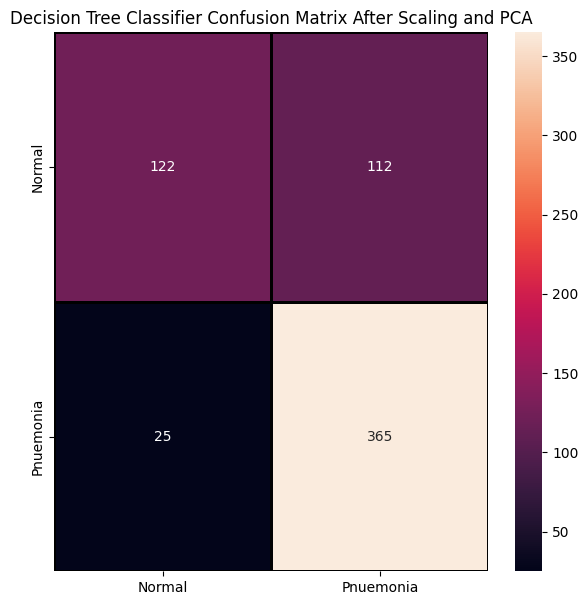

Number of features in decision tree classifier: 1208


In [66]:
# Decision Tree Classifier
# overfitting bad

# Create instance and fit the model
dtc_PCA = DecisionTreeClassifier()
dtc_PCA.fit(X_train_PCA, y_train)

# Print accuracy scores
print('Decision Tree Classifier training accuracy score is: ' + str(dtc_PCA.score(X_train_PCA, y_train)))
print('Decision Tree Classifier testing accuracy score is: ' + str(dtc_PCA.score(X_test_PCA, y_test)))

# Generate confusion matrix plot and classification report 
dtc_PCA_predicted = dtc_PCA.predict(X_test_PCA)
print(classification_report(y_true=y_test, y_pred=dtc_PCA_predicted))
plot_cm(dtc_PCA_predicted, y_test, 'Decision Tree Classifier Confusion Matrix After Scaling and PCA')
print("Number of features in decision tree classifier:", dtc_PCA.tree_.n_features)


AdaBoost PCA training accuracy score is: 1.0
AdaBoost PCA testing accuracy score is: 0.7740384615384616
              precision    recall  f1-score   support

           0       0.81      0.52      0.63       234
           1       0.76      0.93      0.84       390

    accuracy                           0.77       624
   macro avg       0.79      0.72      0.73       624
weighted avg       0.78      0.77      0.76       624



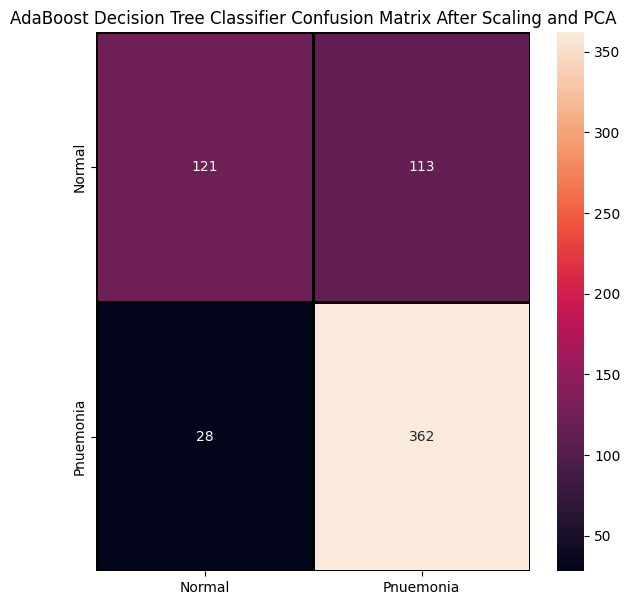

Number of features in decision tree classifier: 1208


In [65]:
#dtc with pca and adaBoost

# Create instance of the AdaBoost classifier and fit the model
ada_PCA = AdaBoostClassifier(estimator=dtc_PCA, n_estimators=100, learning_rate=0.001)
ada_PCA.fit(X_train_PCA, y_train)

# Print accuracy scores
print('AdaBoost PCA training accuracy score is: ' + str(ada_PCA.score(X_train_PCA, y_train)))
print('AdaBoost PCA testing accuracy score is: ' + str(ada_PCA.score(X_test_PCA, y_test)))

# Generate confusion matrix plot and classification report 
ada_PCA_predicted = ada_PCA.predict(X_test_PCA)
print(classification_report(y_true=y_test, y_pred=ada_PCA_predicted))
plot_cm(ada_PCA_predicted, y_test, 'AdaBoost Decision Tree Classifier Confusion Matrix After Scaling and PCA')
print("Number of features in decision tree classifier:", dtc_PCA.tree_.n_features)


### LDA

In [48]:
# Prepare training and testing data with LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=1)
X_train_LDA = clf.fit_transform(X_train_scaled, y_train)
X_test_LDA = clf.fit_transform(X_test_scaled, y_test)


### Training with LDA

Logistic Regression training accuracy score is: 1.0
Logistic Regression testing accuracy score is: 0.7964743589743589
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       234
           1       0.75      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.88      0.73      0.74       624
weighted avg       0.85      0.80      0.77       624



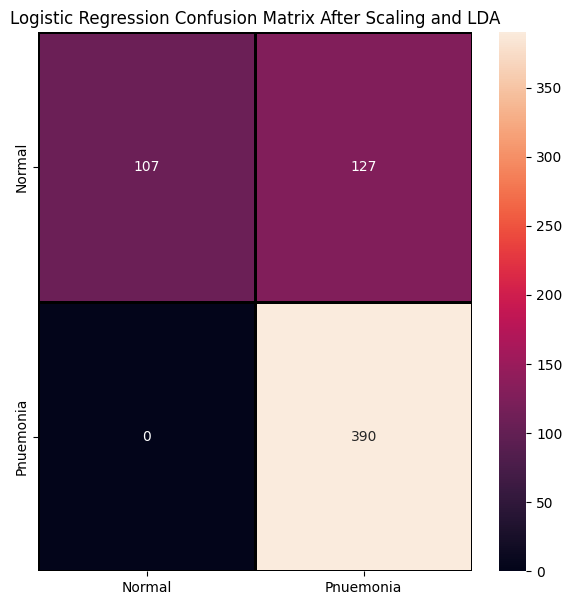

In [94]:
#Log reg 

# Create instance and fit the model 
log_reg_LDA  = LogisticRegression(C=0.5)
log_reg_LDA.fit(X_train_LDA, y_train)

# Print accuracy scores 
print('Logistic Regression training accuracy score is: ' + str(log_reg_LDA.score(X_train_LDA, y_train)))
print('Logistic Regression testing accuracy score is: ' + str(log_reg_LDA.score(X_test_LDA, y_test)))

# Generate confusion matrix plot and classification report 
log_reg_LDA_predicted = log_reg_LDA.predict(X_test_LDA)
print(classification_report(y_true=y_test, y_pred=log_reg_LDA_predicted))
plot_cm(log_reg_LDA_predicted, y_test, 'Logistic Regression Confusion Matrix After Scaling and LDA') 


SVM training accuracy score is: 1.0
SVM testing accuracy score is: 0.8381410256410257
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       234
           1       0.79      1.00      0.89       390

    accuracy                           0.84       624
   macro avg       0.90      0.78      0.81       624
weighted avg       0.87      0.84      0.83       624



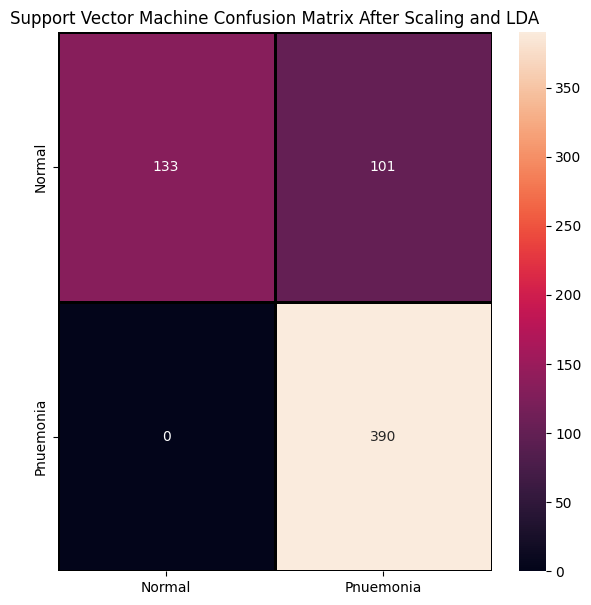

In [86]:
# SVM 

# Create instance and fit the model 
svm_LDA = SVC() 
svm_LDA.fit(X_train_LDA, y_train)

# Print accuracy scores 
print('SVM training accuracy score is: ' + str(svm_LDA.score(X_train_LDA, y_train)))
print('SVM testing accuracy score is: ' + str(svm_LDA.score(X_test_LDA, y_test)))

# Generate confusion matrix plot and classification report 
svm_LDA_predicted = svm_LDA.predict(X_test_LDA)
print(classification_report(y_true=y_test, y_pred=svm_LDA_predicted))
plot_cm(svm_LDA_predicted, y_test, 'Support Vector Machine Confusion Matrix After Scaling and LDA')

k-NN training accuracy score is: 1.0
k-NN testing accuracy score is: 0.8301282051282052
              precision    recall  f1-score   support

           0       1.00      0.55      0.71       234
           1       0.79      1.00      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.87      0.83      0.82       624



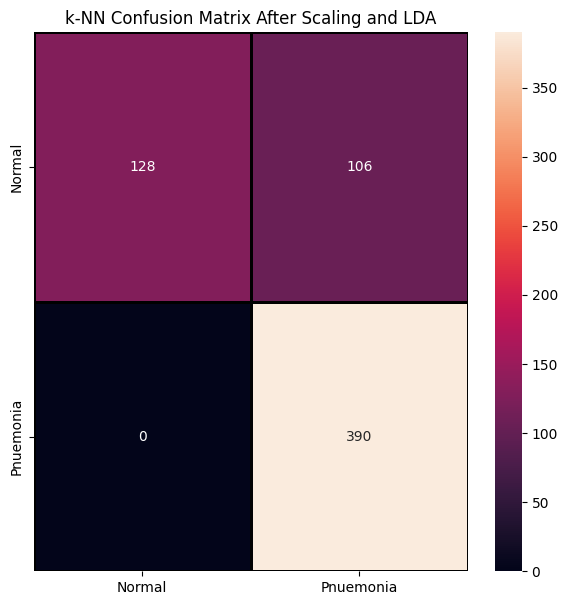

In [87]:
#knn

# Create instance and fit the model
knn_LDA = KNeighborsClassifier(n_neighbors=6)
knn_LDA.fit(X_train_LDA, y_train)

# Print accuracy scores
print('k-NN training accuracy score is: ' + str(knn_LDA.score(X_train_LDA, y_train)))
print('k-NN testing accuracy score is: ' + str(knn_LDA.score(X_test_LDA, y_test)))

# Generate confusion matrix plot and classification report 
knn_LDA_predicted = knn_LDA.predict(X_test_LDA)
print(classification_report(y_true=y_test, y_pred=knn_LDA_predicted))
plot_cm(knn_LDA_predicted, y_test, 'k-NN Confusion Matrix After Scaling and LDA')

Decision Tree Classifier training accuracy score is: 1.0
Decision Tree Classifier testing accuracy score is: 0.9086538461538461
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       234
           1       0.87      1.00      0.93       390

    accuracy                           0.91       624
   macro avg       0.94      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



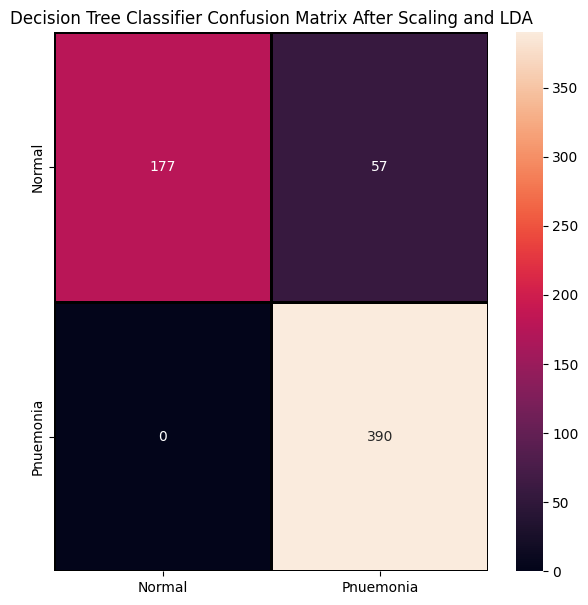

Number of features in decision tree classifier: 1208


In [64]:
# Decision Tree Classifier
# overfitting bad

# Create instance and fit the model
dtc_LDA = DecisionTreeClassifier(max_depth=3)
dtc_LDA.fit(X_train_LDA, y_train)

# Print accuracy scores
print('Decision Tree Classifier training accuracy score is: ' + str(dtc_LDA.score(X_train_LDA, y_train)))
print('Decision Tree Classifier testing accuracy score is: ' + str(dtc_LDA.score(X_test_LDA, y_test)))

# Generate confusion matrix plot and classification report 
dtc_LDA_predicted = dtc_LDA.predict(X_test_LDA)
print(classification_report(y_true=y_test, y_pred=dtc_LDA_predicted))
plot_cm(dtc_LDA_predicted, y_test, 'Decision Tree Classifier Confusion Matrix After Scaling and LDA')
print("Number of features in decision tree classifier:", dtc_PCA.tree_.n_features)


AdaBoost LDA training accuracy score is: 1.0
AdaBoost LDA testing accuracy score is: 0.9086538461538461
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       234
           1       0.87      1.00      0.93       390

    accuracy                           0.91       624
   macro avg       0.94      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624



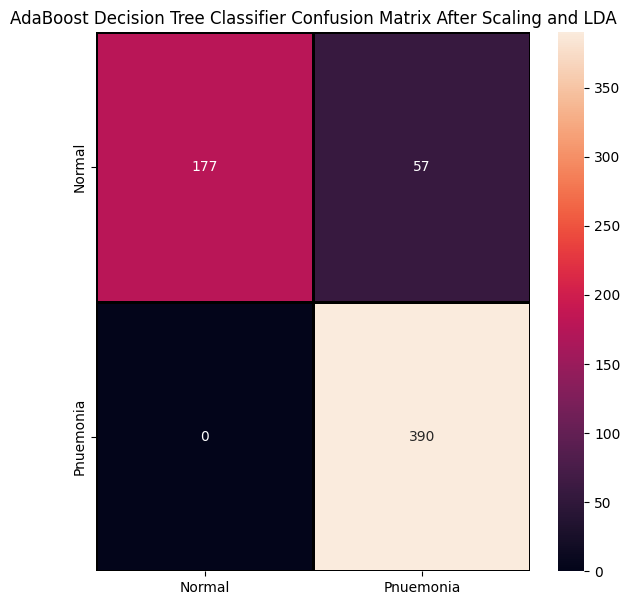

In [63]:
#dtc with lda and adaBoost

# Create instance of the AdaBoost classifier and fit the model
ada_LDA = AdaBoostClassifier(estimator=dtc_LDA, n_estimators=100, learning_rate=0.001)
ada_LDA.fit(X_train_LDA, y_train)

# Print accuracy scores
print('AdaBoost LDA training accuracy score is: ' + str(ada_LDA.score(X_train_LDA, y_train)))
print('AdaBoost LDA testing accuracy score is: ' + str(ada_LDA.score(X_test_LDA, y_test)))

# Generate confusion matrix plot and classification report 
ada_predicted = ada_LDA.predict(X_test_LDA)
print(classification_report(y_true=y_test, y_pred=ada_predicted))
plot_cm(ada_predicted, y_test, 'AdaBoost Decision Tree Classifier Confusion Matrix After Scaling and LDA')